# TWPA Wrapper of JosephsonCircuits.jl

This notebook handles the Julia simulation of nonlinear circuits using Kevin O'Brien's JosephsonCircuits.jl package.  

**Workflow:**
1. Set up Julia environment and JosephsonCircuits.jl  
2. Configuration Classes  
3. User Inputs  
4. Load Flattened Netlist  
5. Build Circuit in Julia (Modified version with NL support)  
6. Run Harmonic Balance Simulation  
7. Results extraction and Plotting  
8. Save results with metadata  
9. Load results

In [ ]:
# Cell 1a: Initial Setup (Run ONCE per session)
# Julia configuration is controlled by julia_setup.py constants:
# - USE_LOCAL_FORK: Toggle local development vs remote
# - USE_GITHUB_FORK: Toggle GitHub fork vs registered (when USE_LOCAL_FORK=False)

from twpa_design import julia_setup

# Initialize julia_ready flag
julia_ready = False

# Setup Julia (configuration is in julia_setup.py)
print("🚀 Setting up Julia...")
jl = julia_setup.get_julia_for_session()

# Try to load JosephsonCircuits
try:
    jl.eval("using JosephsonCircuits")
    
    # Verify what version is loaded
    actual_path = jl.eval("pathof(JosephsonCircuits)")
    print(f"✅ SUCCESS! Using JosephsonCircuits from: {actual_path}")
    
    # Use helper function to check which version (no hardcoded UUIDs!)
    source_type = julia_setup.check_package_source(jl)
    
    if source_type == "local":
        print("🔥 Hot-reloading enabled - edit .jl files and changes auto-reload!")
    elif source_type == "github":
        print("📦 Using GitHub fork with Taylor expansion feature")
    elif source_type == "registered":
        print("📦 Using registered version")
    else:
        print("⚠️ Could not determine package source")
    
    julia_ready = True
        
except Exception as e:
    print(f"❌ Failed to load JosephsonCircuits: {e}")
    print("Check julia_setup.py configuration")
    julia_ready = False

In [ ]:
# Cell 1b: Switch Julia Version (Optional - requires kernel restart first)
# 
# To switch between local fork / GitHub fork / registered version:
# 1. Restart the kernel
# 2. Edit julia_setup.py and change the configuration constants:
#    - USE_LOCAL_FORK = True/False
#    - USE_GITHUB_FORK = True/False
# 3. Re-run Cell 1a
#
# Configuration options:
# - USE_LOCAL_FORK=True  → Local development with hot-reloading
# - USE_LOCAL_FORK=False, USE_GITHUB_FORK=True  → GitHub PR branch
# - USE_LOCAL_FORK=False, USE_GITHUB_FORK=False → Kevin's registered version

print("ℹ️ To switch Julia version:")
print("1. Restart kernel")
print("2. Edit USE_LOCAL_FORK and USE_GITHUB_FORK in julia_setup.py")
print("3. Re-run Cell 1a")

In [2]:
# Cell 2: Configuration Classes

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import os
import sys
import json
from twpa_design.plots_params import *
import matplotlib.ticker as ticker

from twpa_design.helper_functions import filecounter


# Physical constants
FLUX_QUANTUM = 2.067833848e-15  # Wb (Φ₀)

@dataclass
class TWPASimulationConfig:
    """Configuration for TWPA simulation
    
    Note: Physical properties like dielectric loss are part of the netlist,
    not simulation configuration. This class only contains parameters that 
    control how the simulation is run, not what is being simulated.
    """
    
    # Frequency range for signal sweep
    freq_start_GHz: float = 4.0
    freq_stop_GHz: float = 10.0
    freq_step_GHz: float = 0.1
    
    # Pump parameters
    pump_freq_GHz: float = 7.12
    pump_current_A: float = 45e-6  # 45 μA
    pump_port: int = 1  # Port for pump injection
    
    # Signal parameters
    signal_port: int = 1  # Port for signal injection
    output_port: int = 2  # Port for output
    
    # DC bias parameters - Current mode
    enable_dc_bias: bool = False  # This controls the 'dc' parameter in hbsolve
    dc_current_A: Optional[float] = None  # DC current in Amperes
    dc_port: int = 1  # Port for DC bias injection
    
    # DC bias parameters - Flux mode
    dc_flux_bias: Optional[float] = None  # DC flux bias as fraction of Φ₀ (e.g., 1/3)
    mutual_inductance_H: Optional[float] = None  # Mutual inductance in Henries
    
    # Harmonic balance settings
    Npumpharmonics: int = 20
    Nmodulationharmonics: int = 10
    
    # Additional solver settings
    enable_three_wave_mixing: bool = False  # Default: disabled
    enable_four_wave_mixing: bool = True   # Default: enabled (standard TWPA operation)
    
    # Numerical solver parameters (with JosephsonCircuits.jl defaults)
    iterations: Optional[int] = None  # Default: 1000
    ftol: Optional[float] = None  # Default: 1e-8
    switchofflinesearchtol: Optional[float] = None  # Default: 1e-5
    alphamin: Optional[float] = None  # Default: 1e-4
    sorting: str = "name"  # Default in hbsolve is "number", but we use "name" for consistency
    
    def __post_init__(self):
        """Validate and compute DC bias after initialization"""
        if self.enable_dc_bias:
            self._compute_dc_bias()
    
    def _compute_dc_bias(self):
        """Compute DC current from flux if needed"""
        if self.dc_flux_bias is not None and self.mutual_inductance_H is not None:
            # Calculate DC current from flux
            calculated_current = self.dc_flux_bias * FLUX_QUANTUM / self.mutual_inductance_H
            
            if self.dc_current_A is not None:
                # Both specified - warn user
                print(f"⚠️  Warning: Both dc_current_A and dc_flux_bias specified.")
                print(f"   Using flux-based calculation: {calculated_current*1e6:.1f} μA")
                print(f"   (Ignoring specified current: {self.dc_current_A*1e6:.1f} μA)")
            
            self.dc_current_A = calculated_current
            
        elif self.dc_flux_bias is not None and self.mutual_inductance_H is None:
            raise ValueError("dc_flux_bias specified but mutual_inductance_H is missing!")
        
        elif self.dc_current_A is None:
            # No DC bias specified at all
            self.dc_current_A = 0.0
    
    def frequency_array(self) -> np.ndarray:
        """Generate frequency array in Hz"""
        freqs_GHz = np.arange(self.freq_start_GHz, self.freq_stop_GHz + self.freq_step_GHz, self.freq_step_GHz)
        return freqs_GHz * 1e9
    
    def get_sources(self) -> List[Dict]:
        """Generate source configuration for JosephsonCircuits.jl"""
        sources = []
        
        # Add DC bias if enabled
        if self.enable_dc_bias and self.dc_current_A != 0:
            sources.append({
                'mode': (0,),  # DC is mode 0
                'port': self.dc_port,
                'current': self.dc_current_A
            })
        
        # Add pump (always added if pump current is non-zero)
        if self.pump_current_A != 0:
            sources.append({
                'mode': (1,),  # Pump is mode 1
                'port': self.pump_port,
                'current': self.pump_current_A
            })
        
        return sources
    
    def get_solver_options(self) -> Dict:
        """Get additional solver options"""
        options = {}
        
        # Boolean options for special analysis modes
        if self.enable_dc_bias:
            options['dc'] = True
            
        if self.enable_three_wave_mixing:
            options['threewavemixing'] = True
            
        if self.enable_four_wave_mixing:
            options['fourwavemixing'] = True
        
        # Numerical solver parameters if specified (otherwise use hbsolve defaults)
        if self.iterations is not None:
            options['iterations'] = self.iterations
            
        if self.ftol is not None:
            options['ftol'] = self.ftol
            
        if self.switchofflinesearchtol is not None:
            options['switchofflinesearchtol'] = self.switchofflinesearchtol
            
        if self.alphamin is not None:
            options['alphamin'] = self.alphamin
            
        # Sorting is always specified (we default to "name" for consistency)
        options['sorting'] = f':{self.sorting}'
            
        return options
    
    def print_config(self):
        """Print simulation configuration"""
        print("=== Simulation Configuration ===")
        print(f"Signal frequency range: {self.freq_start_GHz} - {self.freq_stop_GHz} GHz")
        print(f"Frequency step: {self.freq_step_GHz} GHz")
        print(f"\nPump Configuration:")
        print(f"  Frequency: {self.pump_freq_GHz} GHz")
        print(f"  Current: {self.pump_current_A*1e6:.1f} μA")
        print(f"  Port: {self.pump_port}")
        print(f"\nSignal Configuration:")
        print(f"  Port: {self.signal_port}")
        print(f"  Output port: {self.output_port}")
        
        if self.enable_dc_bias:
            print(f"\nDC Bias Configuration:")
            print(f"  Current: {self.dc_current_A*1e6:.1f} μA")
            print(f"  Port: {self.dc_port}")
            
            if self.dc_flux_bias is not None:
                print(f"  Flux bias: {self.dc_flux_bias:.3f} Φ₀")
                if self.dc_flux_bias == 1/3:
                    print(f"  (Φ₀/3 - optimal for SQUID modulation)")
                print(f"  Mutual inductance: {self.mutual_inductance_H*1e12:.1f} pH")
        
        print(f"\nHarmonic Balance:")
        print(f"  Pump harmonics: {self.Npumpharmonics}")
        print(f"  Modulation harmonics: {self.Nmodulationharmonics}")
        
        if self.enable_three_wave_mixing or self.enable_four_wave_mixing != True:
            print(f"\nNonlinear Mixing:")
            if self.enable_three_wave_mixing:
                print(f"  Three-wave mixing: Enabled")
            if not self.enable_four_wave_mixing:
                print(f"  Four-wave mixing: Disabled (non-standard!)")


# Helper function for easy flux-based DC bias calculation
def flux_bias_config(flux_over_phi0: float, mutual_inductance_pH: float) -> dict:
    """
    Helper to create DC bias configuration from flux
    
    Args:
        flux_over_phi0: Desired flux as fraction of Φ₀ (e.g., 1/3)
        mutual_inductance_pH: Mutual inductance in picoHenries
    
    Returns:
        Dictionary of config parameters
    
    Example:
        config = TWPASimulationConfig(
            **flux_bias_config(1/3, 2.2),  # Φ₀/3 with 2.2 pH
            freq_start_GHz=5.0,
            # ... other parameters
        )
    """
    return {
        'enable_dc_bias': True,
        'dc_flux_bias': flux_over_phi0,
        'mutual_inductance_H': mutual_inductance_pH * 1e-12
    }


def build_julia_sources_string(config: TWPASimulationConfig) -> str:
    """Build the sources array string for Julia evaluation"""
    sources = config.get_sources()
    
    if not sources:
        return "sources = []"
    
    source_strings = []
    for source in sources:
        mode_str = f"mode={source['mode']}"
        port_str = f"port={source['port']}"
        current_str = f"current={source['current']}"
        source_strings.append(f"({mode_str},{port_str},{current_str})")
    
    return f"sources = [{','.join(source_strings)}]"


def build_hbsolve_string(config: TWPASimulationConfig) -> str:
    """Build the hbsolve command string with all options"""
    
    # Basic command
    cmd = "sol = hbsolve(ws, wp, sources, Nmodulationharmonics, Npumpharmonics, circuit, circuitdefs"
    
    # Add optional parameters
    options = config.get_solver_options()
    if options:
        option_strings = []
        for key, value in options.items():
            if isinstance(value, bool):
                option_strings.append(f"{key}={str(value).lower()}")
            elif isinstance(value, str):
                option_strings.append(f"{key}={value}")  # For sorting=:name
            elif isinstance(value, (int, float)):
                option_strings.append(f"{key}={value}")
            else:
                option_strings.append(f"{key}={value}")
        
        # Sort to ensure consistent order
        option_strings.sort()
        cmd += ", " + ", ".join(option_strings)
    
    cmd += ")"
    
    return cmd


@dataclass
class TWPAResults:
    """Container for TWPA simulation results"""
    frequencies_GHz: np.ndarray
    S11: np.ndarray
    S12: np.ndarray
    S21: np.ndarray
    S22: np.ndarray
    quantum_efficiency: np.ndarray
    commutation_error: np.ndarray
    idler_response: np.ndarray
    backward_idler_response: Optional[np.ndarray] = None
    modes: Optional[List] = None
    
    def save_results(self, filename: str, metadata: dict = None):
        """Save results to file with optional metadata
        
        Args:
            filename: Output filename (should end with .npz)
            metadata: Optional dictionary of metadata to save
        """
        save_dict = {
            'frequencies_GHz': self.frequencies_GHz,
            'S11': self.S11,
            'S12': self.S12,
            'S21': self.S21,
            'S22': self.S22,
            'quantum_efficiency': self.quantum_efficiency,
            'commutation_error': self.commutation_error,
            'idler_response': self.idler_response,
            'backward_idler_response': self.backward_idler_response,
            'modes': self.modes
        }
        
        # Add metadata if provided - store as JSON string
        if metadata is not None:
            import json
            save_dict['metadata'] = np.array(json.dumps(metadata))
        
        np.savez_compressed(filename, **save_dict)
        print(f"Results saved to: {filename}")
        
    @classmethod
    def load(cls, filename: str):
        """Load TWPA results and metadata from file
        
        Args:
            filename: Input filename (with or without path and extension)
            
        Returns:
            tuple: (TWPAResults instance, metadata dict)
        """
        import json
        import os
        
        # Handle filename
        if not filename.endswith('.npz'):
            filename += '.npz'
        
        # If no path specified, assume results directory
        if os.path.sep not in filename and '/' not in filename:
            from twpa_design import RESULTS_DIR
            filename = os.path.join(str(RESULTS_DIR), filename)
        
        # Check if file exists
        if not os.path.exists(filename):
            raise FileNotFoundError(f"File not found: {filename}")
        
        # Load data
        data = np.load(filename, allow_pickle=True)
        
        # Create TWPAResults instance
        results = cls(
            frequencies_GHz=data['frequencies_GHz'],
            S11=data['S11'],
            S12=data['S12'],
            S21=data['S21'],
            S22=data['S22'],
            quantum_efficiency=data['quantum_efficiency'],
            commutation_error=data['commutation_error'],
            idler_response=data['idler_response'],
            backward_idler_response=data.get('backward_idler_response', None),
            modes=data['modes'].tolist() if 'modes' in data else None
        )
        
        # Load metadata if present
        metadata = {}
        if 'metadata' in data:
            metadata = json.loads(str(data['metadata']))
        
        return results, metadata
    
def setup_for_plotting(results, metadata):
    """Set up variables needed to rerun plotting cells after loading results"""
    
    # Set the main variables that cells 7 and 8 expect
    global sim_results, sim_config, simulation_success, amp_type, is_reflection_amp
    global gain_param, gain_data, component_count, performance_metrics
    global NETLIST_NAME
    
    # Basic setup
    sim_results = results
    simulation_success = True
    
    # Recreate sim_config from metadata (only the fields needed for plotting)
    class SimpleConfig:
        pass
    
    sim_config = SimpleConfig()
    sim_config.freq_start_GHz = metadata.get('freq_start_GHz', results.frequencies_GHz[0])
    sim_config.freq_stop_GHz = metadata.get('freq_stop_GHz', results.frequencies_GHz[-1])
    sim_config.pump_freq_GHz = metadata.get('pump_freq_GHz', 0)
    sim_config.signal_port = metadata.get('signal_port', 1)
    sim_config.output_port = metadata.get('output_port', 2)
    sim_config.pump_current_A = metadata.get('pump_current_A', 0)
    NETLIST_NAME = metadata.get('netlist_name', 'unknown_netlist')
    
    # Determine amplifier type
    is_reflection_amp = (sim_config.signal_port == sim_config.output_port)
    amp_type = metadata.get('amplifier_type', 
                            "Reflection Amplifier (PA)" if is_reflection_amp else "Transmission Amplifier (TWPA)")
    
    # Determine gain parameter and data
    if is_reflection_amp:
        if sim_config.signal_port == 1:
            gain_param = "S11"
            gain_data = sim_results.S11
        else:
            gain_param = "S22"
            gain_data = sim_results.S22
    else:
        if sim_config.signal_port == 1 and sim_config.output_port == 2:
            gain_param = "S21"
            gain_data = sim_results.S21
        else:
            gain_param = "S12"
            gain_data = sim_results.S12
    
    # Set other variables if available in metadata
    component_count = metadata.get('component_count', 0)
    
    # Recreate performance metrics
    performance_metrics = {
        'amplifier_type': amp_type,
        'gain_parameter': gain_param,
        'max_gain_dB': metadata.get('max_gain_dB', np.max(10*np.log10(gain_data))),
        'peak_frequency_GHz': metadata.get('peak_frequency_GHz', 0),
        'bandwidth_GHz': metadata.get('bandwidth_GHz', 0),
        'max_qe': np.max(sim_results.quantum_efficiency),
        'min_cm_error': np.min(np.abs(sim_results.commutation_error))
    }
    
    print("✅ Variables set up for plotting.")

In [19]:
# 3. User Inputs

""" Some additional description of the non obvious keywords
- `maxintermodorder=Inf`: the maximum intermod order as defined by the sum of
    the absolute values of the integers multiplying each of the frequencies
    being less than or equal to `maxintermodorder`. This performs a diamond
    truncation of the discrete Fourier space.
- `iterations = 1000`: the number of iterations before the nonlinear solver
    returns an error.
- `ftol = 1e-8`: the function tolerance defined we considered converged,
    defined as norm(F)/norm(x) < ftol or norm(F,Inf) <= ftol.
- `switchofflinesearchtol = 1e-5`: the function tolerance at which we switch
    from Newton with linesearch to only Newton. For easily converging
    functions, setting this to zero can speed up simulations.
- `alphamin = 1e-4`: the minimum step size relative to 1 for the linesearch.
- `sorting = :number`: sort the nodes by:
    `:name`: Sort the vector of strings. This always works but leads
    to results like "101" comes before "11".
    `:number`: Convert the node strings to integer and sort by these
    (this errors if the nodes names cannot be converted to integers).
    `:none`: Don't perform any sorting except to place the ground node
    first. In other words, order the nodes in the order they are found in
    `circuit`.
"""

from twpa_design import NETLISTS_DIR
NETLIST_DIR = str(NETLISTS_DIR)  # Convert Path to string for compatibility

simulation_type = "ktwpa"  # Change this to select configuration or

###########################################################

if simulation_type == "jtwpa":

    # file name to load
    NETLIST_NAME = "4wm_jtwpa_2002cells_01"

    # Simulation parameters
    sim_config = TWPASimulationConfig(
        freq_start_GHz = 4.0,
        freq_stop_GHz = 12.0,
        freq_step_GHz = 0.01,
        pump_freq_GHz = 8.63,     # Adjust based on your design
        pump_current_A = 2.7e-6,   # Adjust based on your design
        Npumpharmonics = 20,
        Nmodulationharmonics = 10
    )


elif simulation_type == "b_jtwpa":

    # file name to load
    NETLIST_NAME = "b_jtwpa_2000cells_01"

    # Simulation parameters
    sim_config = TWPASimulationConfig(
        freq_start_GHz = 4.0,
        freq_stop_GHz = 12.0,
        freq_step_GHz = 0.01,
        pump_freq_GHz = 14.985,
        
        pump_current_A = 1.1e-6,   # Adjust based on your design

        pump_port = 2,      # Pump on port 2
        signal_port = 1,    # Signal on port 1
        output_port = 2,    # Output from port 2
        
    #    enable_dielectric_loss = True,
    #    loss_tangent = 1e-4,  # tan(δ) = 0.002

        enable_three_wave_mixing = True,  # otherwise default is False in hbsolve
        enable_four_wave_mixing = True,   # Also enabled

        Npumpharmonics = 20,
        Nmodulationharmonics = 10,
    )

elif simulation_type == "ktwpa":

    # file name to load
    NETLIST_NAME = "4wm_ktwpa_5004cells_01"

    # Simulation parameters
    sim_config = TWPASimulationConfig(
        freq_start_GHz = 4, # 7
        freq_stop_GHz = 14, # 10
        freq_step_GHz = 0.01, # 0.1
        pump_freq_GHz = 9.1, # 9.05    # Adjust based on your design 9.0
        pump_current_A = 22e-6, # 14e-6,   # Adjust based on your design        
        Npumpharmonics = 10, # 10 I think I need to stay below the line cutoff
        Nmodulationharmonics = 10, # 10        
        iterations = 1000, # 1000       
        ftol = 1e-5, # For some reason, I need increase the convergence tolerance
    )
    
# Print configuration
sim_config.print_config()

=== Simulation Configuration ===
Signal frequency range: 4 - 14 GHz
Frequency step: 0.01 GHz

Pump Configuration:
  Frequency: 9.1 GHz
  Current: 22.0 μA
  Port: 1

Signal Configuration:
  Port: 1
  Output port: 2

Harmonic Balance:
  Pump harmonics: 10
  Modulation harmonics: 10


In [20]:
# Cell 4: Load Flattened Netlist
if julia_ready:
    print("Loading flattened netlist from file...")
    
    netlist_file = f"{NETLIST_DIR}/{NETLIST_NAME}.py"
    
    if not os.path.exists(netlist_file):
        print(f"✗ Flattened netlist not found: {netlist_file}")
        print(f"Available files in {NETLIST_DIR}:")
        if os.path.exists(NETLIST_DIR):
            py_files = [f for f in os.listdir(NETLIST_DIR) if f.endswith('.py')]
            if py_files:
                for f in py_files:
                    print(f"  {f}")
            else:
                print("  No .py files found")
        else:
            print(f"  Directory {NETLIST_DIR} does not exist")
            print(f"  Run the netlist converter first!")
        julia_ready = False
    else:
        # Load the Python file containing components and parameters
        namespace = {}
        with open(netlist_file, 'r') as f:
            exec(f.read(), namespace)
        
        # Extract all needed data from the flattened netlist file
        jc_components = namespace.get('jc_components', [])
        circuit_parameters = namespace.get('circuit_parameters', {})
        metadata = namespace.get('metadata', {})
        
        print(f"✓ Loaded netlist from: {netlist_file}")
        print(f"✓ Components: {len(jc_components)}")
        print(f"✓ Parameters: {len(circuit_parameters)}")
        
        # Detect dielectric loss from the netlist
        def detect_dielectric_loss(circuit_params):
            """Detect if dielectric loss is present in circuit parameters"""
            for param, value in circuit_params.items():
                if (param.startswith('C') and 
                    isinstance(value, str) and 
                    'im' in value and 
                    '/' in value):
                    # Extract loss tangent from expression like "7.66e-14/(1+3e-3im)"
                    import re
                    match = re.search(r'\(1\+([0-9.e-]+)im\)', value)
                    if match:
                        return True, float(match.group(1))
            return False, 0.0
        
        # Check both metadata and parameters for loss info
        netlist_has_loss = False
        netlist_loss_tangent = 0.0
        
        # First check metadata (preferred)
        if metadata.get('dielectric_loss_enabled', False):
            netlist_has_loss = True
            netlist_loss_tangent = metadata.get('loss_tangent', 0.0)
            print(f"✓ Dielectric loss detected from metadata: tan δ = {netlist_loss_tangent}")
        else:
            # Fallback: auto-detect from parameters
            detected, tan_delta = detect_dielectric_loss(circuit_parameters)
            if detected:
                netlist_has_loss = True
                netlist_loss_tangent = tan_delta
                print(f"✓ Dielectric loss detected from parameters: tan δ = {netlist_loss_tangent}")
            else:
                print("✓ No dielectric loss in netlist")
        
        # Display metadata info
        if metadata:
            print(f"✓ Metadata: "f"{metadata.get('total_cells', 0)} total cells")
    
    # Display sample components
    print("\nSample components:")
    for i, (name, node1, node2, value) in enumerate(jc_components[:5]):
        print(f"  {name}: {node1} -> {node2} = {value}")
    print(f" ... ")        
    for i, (name, node1, node2, value) in enumerate(jc_components[len(jc_components) - 5:]):
        print(f"  {name}: {node1} -> {node2} = {value}")        
    
    print(f"total number of components: {len(jc_components)}")
    
    # Display parameters
    print(f"\nCircuit parameters:")
    for param, value in list(circuit_parameters.items())[:10]:  # Show first 10
        if isinstance(value, str):
            print(f"  {param}: {value}")  # Complex values with loss
        else:
            print(f"  {param}: {value:.6e}")
    if len(circuit_parameters) > 10:
        print(f"  ... and {len(circuit_parameters) - 10} more parameters")

    # Store component count for later use
    component_count = len(jc_components)

Loading flattened netlist from file...
✓ Loaded netlist from: C:\Users\mbm2\OneDrive - NIST\theory\twpa_design\src\twpa_design\netlists/4wm_ktwpa_5004cells_01.py
✓ Components: 11680
✓ Parameters: 13
✓ No dielectric loss in netlist
✓ Metadata: 5004 total cells

Sample components:
  P1_0: 1 -> 0 = 1
  R1_0: 1 -> 0 = R_port
  NLTLsec_0: 1 -> 2 = poly L0, c1, c2
  CTLsec_0: 2 -> 0 = C_TL_0
  NLTLsec_1: 2 -> 3 = poly L0, c1, c2
 ... 
  LiLF2_1_5003: 6114 -> 6117 = LiLF2_1_0
  CiLF2_1_5003: 6117 -> 6115 = CiLF2_1_0
  C0CF1_5003: 6115 -> 0 = C0CF1_0
  R6115_0: 6115 -> 0 = R_port
  P6115_0: 6115 -> 0 = 2
total number of components: 11680

Circuit parameters:
  C0CF1_0: 4.867833e-14
  C_TL_0: 5.132876e-14
  C_TL_1: 4.867833e-14
  C_TL_2: 4.196722e-14
  C_TL_3: 3.433562e-14
  C_TL_4: 2.935445e-14
  CiLF2_1_0: 5.355137e-14
  L0: 1.000000e-10
  L0LF2_rem: 2.072484e-12
  LiLF2_1_0: 4.925128e-09
  ... and 3 more parameters


In [21]:
# Cell 5: Build Circuit in Julia (Modified version with NL support)

if julia_ready and 'jc_components' in locals():
    print("Building circuit in Julia...")
    
    # Helper functions for circuit building
    def parse_spice_value(value_str):
        """Parse SPICE-style values with units"""
        if not isinstance(value_str, str):
            return float(value_str)
        
        unit_multipliers = {
            'f': 1e-15, 'p': 1e-12, 'n': 1e-9, 'u': 1e-6, 
            'm': 1e-3, 'k': 1e3, 'meg': 1e6, 'g': 1e9,
        }
        
        value_str = value_str.lower().strip()
        for unit, multiplier in unit_multipliers.items():
            if value_str.endswith(unit):
                number_part = value_str[:-len(unit)]
                try:
                    return float(number_part) * multiplier
                except ValueError:
                    continue
        return float(value_str)
    
    def clean_node_name(node):
        """Clean node names for Julia compatibility"""
        node_clean = node.replace('.', '_').replace('-', '_')
        if node_clean == '0':
            return '0'  # Ground
        elif node_clean.lower() in ['nin', 'nout']:
            return node_clean
        else:
            return node_clean
    
    def should_include_component(name, value):
        """Determine if component should be included"""
        if name.startswith(('V', 'I')):
            return False  # Skip sources
        if name.startswith(('R', 'L', 'C', 'B', 'P', 'K', 'NL')):  # Added 'NL' for nonlinear elements
            return True   # Include passive components, JJs, NL elements, and ports
        return False
    
    def extract_variables_from_poly(poly_str):
        """Extract symbolic variables from poly string"""
        vars_found = []
        if isinstance(poly_str, str) and poly_str.startswith("poly "):
            # Remove "poly " and split by comma and space
            parts = poly_str[5:].replace(',', ' ').split()
            for part in parts:
                part = part.strip()
                if part:  # Skip empty strings
                    # Try to parse as float, if it fails it's a variable
                    try:
                        float(part)
                    except ValueError:
                        vars_found.append(part)
        return vars_found
    
    def format_value_for_julia(value, parameters):
        """Format component value for Julia"""
        if isinstance(value, str) and value.startswith("poly "):
            # Return the poly string as is, wrapped in quotes
            return f'"{value}"'
        elif value in parameters:
            # For symbolic parameters, check if it's a complex value (has loss)
            param_value = parameters[value]
            if isinstance(param_value, str) and 'im' in param_value:
                # It's already a complex expression, use it directly
                return param_value
            else:
                # Regular numeric value
                return str(param_value)
        elif value in ['1', '2']:  # Port numbers
            return value
        else:
            try:
                float_val = float(value)
                return str(float_val)
            except:
                return f'"{value}"'
    
    # Extract unique symbolic variables (for debugging)
    variables = set()
    
    # First, collect all parameter names
    param_vars = set()
    for param_name in circuit_parameters.keys():
        if param_name.replace('_', '').replace('.', '').isalnum():
            param_vars.add(param_name)
    
    # Then check component values
    poly_vars = set()
    for _, _, _, value in jc_components:
        if isinstance(value, str):
            if value.startswith("poly "):
                # Extract variables from poly string
                extracted = extract_variables_from_poly(value)
                poly_vars.update(extracted)
            elif value in circuit_parameters:
                param_vars.add(value)
            elif value == "Lj":
                poly_vars.add("Lj")
    
    # Combine all variables - both from parameters and poly strings
    variables = param_vars | poly_vars
    variables = sorted(list(variables))
    
    print(f"Parameter variables: {sorted(param_vars)}")
    print(f"Poly string variables: {sorted(poly_vars)}")
    print(f"All variables: {variables}")
    
    # Initialize Julia circuit
    print("Setting up circuit...")
    
    # Convert Python boolean to Julia boolean string
    julia_has_loss = "true" if netlist_has_loss else "false"
    
    julia_setup_code = f"""
    # Initialize circuit - use Any type to handle poly strings
    circuit = Tuple{{String,String,String,Any}}[]
    
    # Create circuitdefs with appropriate type
    if {julia_has_loss}
        circuitdefs = Dict{{Symbol,ComplexF64}}()
    else
        circuitdefs = Dict{{Symbol,Float64}}()
    end
    
    # Setup complete flag
    setup_complete = true
    """
    
    try:
        jl.eval(julia_setup_code)
        setup_ok = jl.eval('setup_complete')
        if setup_ok:
            print(f"✓ Circuit initialization complete")
            print(f"  Found {len(variables)} unique variable names")
        else:
            raise Exception("Setup verification failed")
    except Exception as e:
        print(f"✗ Julia setup failed: {e}")
        circuit_ready = False
    else:
        # Add components
        print("Adding components to circuit...")
        
        # Build all component additions as one big Julia string
        component_additions = []
        component_count = 0
        nl_count = 0
        
        for name, node1, node2, value in jc_components:
            if should_include_component(name, value):
                value_expr = format_value_for_julia(value, circuit_parameters)
                node1_clean = clean_node_name(node1)
                node2_clean = clean_node_name(node2)
                
                component_additions.append(f'push!(circuit,("{name}","{node1_clean}","{node2_clean}",{value_expr}));')
                component_count += 1
                
                if name.startswith("NL"):
                    nl_count += 1
        
        # Execute all component additions in one go
        if component_additions:
            all_components_code = f"""
            # Add all components
            {chr(10).join(component_additions)}
            # Set completion flag
            components_added = true
            """
            
            try:
                jl.eval(all_components_code)
                components_ok = jl.eval('components_added')
                if components_ok:
                    print(f"✓ Successfully added {component_count} components")
                    if nl_count > 0:
                        print(f"  Including {nl_count} NL (nonlinear) elements")
                    failed_components = 0
                else:
                    print("⚠️ Component addition had issues")
                    failed_components = component_count
            except Exception as e:
                print(f"⚠️ Component addition failed: {e}")
                print(f"  Error details: {e}")
                failed_components = component_count
        
        # ====== Build circuit parameters ======
        print("Setting parameter values...")
        
        params_lines = []
        
        # Add each parameter directly - the netlist already has loss applied
        for param, value in circuit_parameters.items():
            if isinstance(value, str):
                # Complex value (already includes loss) or expression
                params_lines.append(f'circuitdefs[:{param}] = {value}')
            else:
                # Regular numeric value
                params_lines.append(f'circuitdefs[:{param}] = {value}')
        
        params_lines.append("circuit_build_complete = true")
        params_code = '\n'.join(params_lines)
        
        # Execute the parameter setting
        try:
            jl.eval(params_code)
            build_complete = jl.eval('circuit_build_complete')
            final_circuit_length = jl.eval('length(circuit)')
            
            if build_complete:
                print(f"✓ Circuit built successfully!")
                print(f"  Total components: {final_circuit_length}")
                if nl_count > 0:
                    print(f"  NL elements: {nl_count}")
                print(f"  Parameters set: {len(circuit_parameters)}")
                if netlist_has_loss:
                    print(f"  Dielectric loss: tan δ = {netlist_loss_tangent}")
                circuit_ready = True
            else:
                circuit_ready = False
        except Exception as e:
            print(f"✗ Parameter setting failed: {e}")
            circuit_ready = False

else:
    circuit_ready = False
    if not julia_ready:
        print("✗ Circuit building skipped - Julia not ready")
    elif 'jc_components' not in locals():
        print("✗ Circuit building skipped - jc_components not found")

Building circuit in Julia...
Parameter variables: ['C0CF1_0', 'C_TL_0', 'C_TL_1', 'C_TL_2', 'C_TL_3', 'C_TL_4', 'CiLF2_1_0', 'L0', 'L0LF2_rem', 'LiLF2_1_0', 'R_port', 'c1', 'c2']
Poly string variables: ['L0', 'c1', 'c2']
All variables: ['C0CF1_0', 'C_TL_0', 'C_TL_1', 'C_TL_2', 'C_TL_3', 'C_TL_4', 'CiLF2_1_0', 'L0', 'L0LF2_rem', 'LiLF2_1_0', 'R_port', 'c1', 'c2']
Setting up circuit...
✓ Circuit initialization complete
  Found 13 unique variable names
Adding components to circuit...
✓ Successfully added 11680 components
  Including 5004 NL (nonlinear) elements
Setting parameter values...
✓ Circuit built successfully!
  Total components: 11680
  NL elements: 5004
  Parameters set: 13


In [22]:
# Cell 6: Run Harmonic Balance Simulation

if circuit_ready:
    print("=== Running Harmonic Balance Simulation ===")
    
    # Determine amplifier type based on configuration
    is_reflection_amp = (sim_config.signal_port == sim_config.output_port)
    amp_type = "Reflection (PA)" if is_reflection_amp else "Transmission (TWPA)"
    gain_param = "S11" if is_reflection_amp else "S21"
    
    print(f"Detected amplifier type: {amp_type}")
    print(f"Will analyze gain using: {gain_param}")
    
    try:
        print("\nSetting up simulation parameters...")
        
        # Create frequency array in Julia
        freqs_Hz = sim_config.frequency_array()
        freq_step_Hz = freqs_Hz[1] - freqs_Hz[0]
        jl.eval(f'ws = 2*pi*collect({freqs_Hz[0]}:{freq_step_Hz}:{freqs_Hz[-1]})')
        
        # Set pump parameters
        jl.eval(f'wp = (2*pi*{sim_config.pump_freq_GHz}*1e9,)')
        
        # Build sources array with port selection
        sources_str = build_julia_sources_string(sim_config)
        jl.eval(sources_str)
        
        # Set harmonic parameters
        jl.eval(f'Npumpharmonics = ({sim_config.Npumpharmonics},)')
        jl.eval(f'Nmodulationharmonics = ({sim_config.Nmodulationharmonics},)')
        
        print("✓ Simulation parameters configured")
        print(f"  Frequency points: {len(freqs_Hz)}")
        print(f"  Frequency range: {freqs_Hz[0]/1e9:.1f} - {freqs_Hz[-1]/1e9:.1f} GHz")
        
        # Display source configuration
        sources = sim_config.get_sources()
        print(f"\n  Source configuration:")
        for source in sources:
            mode_type = "DC" if source['mode'] == (0,) else f"Pump @ {sim_config.pump_freq_GHz} GHz"
            print(f"    {mode_type}: {source['current']*1e6:.1f} μA on port {source['port']}")
        
        # Display dielectric loss info from netlist (not sim_config)
        if 'netlist_has_loss' in globals() and netlist_has_loss:
            print(f"  Dielectric loss: tan δ = {netlist_loss_tangent}")
        
        if sim_config.enable_three_wave_mixing or sim_config.enable_four_wave_mixing:
            print(f"  Nonlinear mixing enabled")
        
        print("\nRunning harmonic balance solver...")
        print("⏱️  This may take several minutes for large circuits...")

        # Clear any previous warnings
        jl.eval("JosephsonCircuits.clear_warning_log()")

        # Build and run the hbsolve command with all options
        hbsolve_cmd = build_hbsolve_string(sim_config)
        jl.eval(f'@time {hbsolve_cmd}')

        # Check for warnings
        warnings = jl.eval("JosephsonCircuits.get_warning_log()")
        if warnings:
            print("\n⚠️  Solver Warnings:")
            for warning in warnings:
                print(f"   {warning}")
            print()

        print("✓ Harmonic balance simulation completed!")
        print("Extracting results...")
        
        # Extract results from Julia
        frequencies_GHz = np.array(jl.eval('ws./(2*pi*1e9)'))
        
        # S-parameters - now with configurable ports
        print("  Extracting S-parameters...")
        
        # Helper function to extract S-parameters
        def extract_s_param(out_port, out_mode, in_port, in_mode):
            return np.array(jl.eval(f'''
            abs2.(sol.linearized.S(
                outputmode={out_mode},
                outputport={out_port},
                inputmode={in_mode},
                inputport={in_port},
                freqindex=:))
            '''))
        
        # Extract main S-parameters based on configuration
        S21 = extract_s_param(sim_config.output_port, (0,), sim_config.signal_port, (0,))
        S12 = extract_s_param(sim_config.signal_port, (0,), sim_config.output_port, (0,))
        S11 = extract_s_param(sim_config.signal_port, (0,), sim_config.signal_port, (0,))
        S22 = extract_s_param(sim_config.output_port, (0,), sim_config.output_port, (0,))
        
        # Quantum efficiency
        print("  Extracting quantum efficiency...")
        QE = np.array(jl.eval(f'''
        sol.linearized.QE((0,),{sim_config.output_port},(0,),{sim_config.signal_port},:)./
        sol.linearized.QEideal((0,),{sim_config.output_port},(0,),{sim_config.signal_port},:)
        '''))
        
        # Commutation relation error
        print("  Extracting commutation relation error...")
        CM_error = np.array(jl.eval(f'1 .- sol.linearized.CM((0,),{sim_config.output_port},:)'))
        
        # Idler response
        print("  Extracting idler response...")
        try:
            idler = np.array(jl.eval(f"abs2.(sol.linearized.S(:,{sim_config.output_port},(0,),{sim_config.signal_port},:)')"))
        except:
            print("    Warning: Could not extract full idler response, using simplified version")
            idler = np.zeros_like(S21)

        # Backward idler response
        print("  Extracting backward idler response...")
        try:
            backward_idler = np.array(jl.eval(f"abs2.(sol.linearized.S(:,{sim_config.signal_port},(0,),{sim_config.output_port},:)')"))
        except:
            print("    Warning: Could not extract backward idler response")
            backward_idler = None
        
        # Get modes from Julia
        try:
            modes = list(jl.eval("sol.linearized.modes"))
        except:
            modes = None

        # Create results object
        sim_results = TWPAResults(
            frequencies_GHz=frequencies_GHz,
            S11=S11, S12=S12, S21=S21, S22=S22,
            quantum_efficiency=QE,
            commutation_error=CM_error,
            idler_response=idler,
            backward_idler_response=backward_idler,
            modes=modes
        )
        
        print("✓ Results extracted successfully!")
        
        # Calculate key metrics using the CORRECT S-parameter
        if is_reflection_amp:
            # For reflection amp, gain is S_XX where X is the signal/output port
            if sim_config.signal_port == 1:
                gain_data = sim_results.S11
                gain_label = "S11"
            else:  # signal_port == 2
                gain_data = sim_results.S22
                gain_label = "S22"
        else:
            # For transmission amp, gain depends on which is input and output
            if sim_config.signal_port == 1 and sim_config.output_port == 2:
                gain_data = sim_results.S21
                gain_label = "S21"
            elif sim_config.signal_port == 2 and sim_config.output_port == 1:
                gain_data = sim_results.S12
                gain_label = "S12"
            else:
                # Shouldn't happen, but handle it
                gain_data = sim_results.S21
                gain_label = "S21"
        
        max_gain_dB = 10*np.log10(np.max(gain_data))
        max_gain_idx = np.argmax(gain_data)
        peak_freq = frequencies_GHz[max_gain_idx]
        
        # Find 3dB bandwidth
        gain_dB = 10*np.log10(gain_data)
        gain_3db = max_gain_dB - 3
        above_3db = gain_dB > gain_3db
        bandwidth_GHz = 0
        if np.any(above_3db):
            freq_3db = frequencies_GHz[above_3db]
            bandwidth_GHz = freq_3db[-1] - freq_3db[0]        
        
        print(f"\n🎯 Quick Results Preview ({amp_type}):")
        print(f"   Max {gain_label} gain: {max_gain_dB:.1f} dB @ {peak_freq:.3f} GHz")
        print(f"   3dB bandwidth: {bandwidth_GHz:.2f} GHz")
        print(f"   Max quantum efficiency: {np.max(QE):.3f}")
        print(f"   Min commutation error: {np.min(np.abs(CM_error)):.2e}")                
        
        simulation_success = True
        
    except Exception as e:
        print(f"✗ Simulation failed: {e}")
        print("\nTroubleshooting tips:")
        print("1. Check circuit parameters are reasonable")
        print("2. Verify port numbers exist in your circuit")
        print("3. For DC bias, ensure the circuit supports it")
        print("4. For dielectric loss, check that capacitor values remain physical")
        print("5. Check Julia console for detailed error messages")
        simulation_success = False
        
else:
    print("✗ Simulation skipped - circuit not ready")
    simulation_success = False

=== Running Harmonic Balance Simulation ===
Detected amplifier type: Transmission (TWPA)
Will analyze gain using: S21

Setting up simulation parameters...
✓ Simulation parameters configured
  Frequency points: 1001
  Frequency range: 4.0 - 14.0 GHz

  Source configuration:
    Pump @ 9.1 GHz: 22.0 μA on port 1
  Nonlinear mixing enabled

Running harmonic balance solver...
⏱️  This may take several minutes for large circuits...
✓ Harmonic balance simulation completed!
Extracting results...
  Extracting S-parameters...
  Extracting quantum efficiency...
  Extracting commutation relation error...
  Extracting idler response...
  Extracting backward idler response...
✓ Results extracted successfully!

🎯 Quick Results Preview (Transmission (TWPA)):
   Max S21 gain: 20.5 dB @ 5.400 GHz
   3dB bandwidth: 9.99 GHz
   Max quantum efficiency: 0.995
   Min commutation error: 8.88e-16


=== Plotting Amplifier Performance ===
Amplifier type: Transmission Amplifier (TWPA)
Gain parameter: S21
Commutation relation |1-CM|:
  Min: 8.88e-16
  Max: 8.98e-12
  Mean: 1.35e-12

Figure saved to: C:\Users\mbm2\OneDrive - NIST\theory\twpa_design\src\twpa_design\results/4wm_ktwpa_5004cells_01_pump9.10GHz_02.svg
✅ Figure saved as file #02


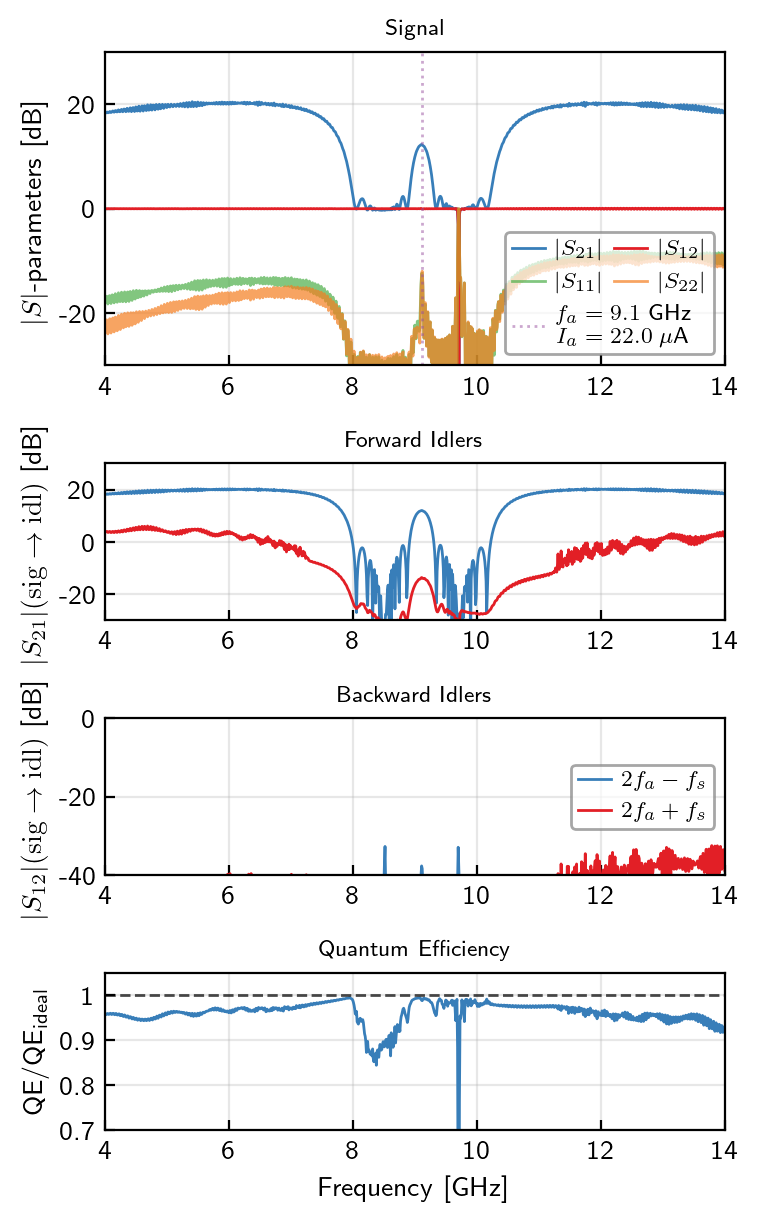

In [23]:
# Cell 7: Results Analysis and Plotting

def get_mode_label(n, pump_freq_GHz):
    """
    Universal labeling for mode (n,) where frequency = fs + n*fa
    When fs + n*fa < 0, the physical frequency is |n|*fa - fs
    """
    if n == 0:
        return "fs"
    elif n > 0:
        if n == 1:
            return f"$f_a + f_s$"    
        else:
            return f"${n}f_a + f_s$"
    else:  # n < 0
        # Negative frequency fs + n*fa corresponds to |n|*fa - fs
        if n == -1:
            return f"$f_a - f_s$"
        else:
            return f"${-n}f_a - f_s$"

linewidth = 1
MAX_MODE_ORDER_TO_PLOT = 2  # Will plot modes n = 0, ±2, ±4, etc.


colors = [blue, red, green, orange, purple, brown]

# Global font size control
fontsize = 10
fontsize_legend = 8
fontsize_title = 8 

if simulation_success and 'sim_results' in locals():

    # Determine amplifier type and correct gain parameter
    is_reflection_amp = (sim_config.signal_port == sim_config.output_port)
    amp_type = "Reflection Amplifier (PA)" if is_reflection_amp else "Transmission Amplifier (TWPA)"
    
    # Determine which S-parameter represents the gain
    if is_reflection_amp:
        # For reflection amp, gain is S_XX where X is the signal/output port
        if sim_config.signal_port == 1:
            gain_param = "S11"
            gain_data = sim_results.S11
        else:  # signal_port == 2
            gain_param = "S22"
            gain_data = sim_results.S22
    else:
        # For transmission amp, gain depends on signal flow direction
        if sim_config.signal_port == 1 and sim_config.output_port == 2:
            gain_param = "S21"
            gain_data = sim_results.S21
        elif sim_config.signal_port == 2 and sim_config.output_port == 1:
            gain_param = "S12"
            gain_data = sim_results.S12
        else:
            # Default fallback
            gain_param = "S21"
            gain_data = sim_results.S21

    print("=== Plotting Amplifier Performance ===")            
    print(f"Amplifier type: {amp_type}")
    print(f"Gain parameter: {gain_param}")

    cm_errors = np.abs(sim_results.commutation_error)
    print(f"Commutation relation |1-CM|:")
    print(f"  Min: {np.min(cm_errors):.2e}")
    print(f"  Max: {np.max(cm_errors):.2e}")
    print(f"  Mean: {np.mean(cm_errors):.2e}")
    if np.max(cm_errors) > 0.01:
        print("  ⚠️ Warning: Maximum error > 1% - check energy conservation")
    print()

    # For reflection amplifiers, determine optimal frequency range for plotting
    plot_freq_min = sim_results.frequencies_GHz[0]
    plot_freq_max = sim_results.frequencies_GHz[-1]
    
    if is_reflection_amp:
        # Find where significant gain occurs
        gain_dB = 10*np.log10(gain_data)
        max_gain_dB = np.max(gain_dB)
    
    # Create 4x1 plot layout
    fig = plt.figure(figsize=(4, 7))
    import matplotlib.gridspec as gridspec
    # Define height ratios: first plot gets more space
    gs = gridspec.GridSpec(4, 1, figure=fig, height_ratios=[2, 1, 1, 1], hspace=0.5)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])
    
    # Plot 1: S-parameters (top left)
    ax1.plot(sim_results.frequencies_GHz, 10*np.log10(sim_results.S21), color=blue, linewidth=linewidth)
    ax1.plot(sim_results.frequencies_GHz, 10*np.log10(sim_results.S12), color=red, linewidth=linewidth)
    ax1.plot(sim_results.frequencies_GHz, 10*np.log10(sim_results.S11), color=green, linewidth=linewidth, alpha=0.7)
    ax1.plot(sim_results.frequencies_GHz, 10*np.log10(sim_results.S22), color=orange, linewidth=linewidth, alpha=0.7)
    
    # Add vertical line at pump frequency
    pump_line = ax1.axvline(sim_config.pump_freq_GHz, color=purple, linestyle=':', alpha=0.5, label=rf'$f_a = {sim_config.pump_freq_GHz}$ GHz' + '\n' + rf'$I_a = {sim_config.pump_current_A*1e6:.1f}$ uA')
    
    # Create custom legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Rectangle

    # Create legend handles
    s21_handle = Line2D([0], [0], color=blue, linewidth=linewidth, label=r'$|S_{21}|$')
    s12_handle = Line2D([0], [0], color=red, linewidth=linewidth, label=r'$|S_{12}|$')
    s11_handle = Line2D([0], [0], color=green, linewidth=linewidth, alpha=0.7, label=r'$|S_{11}|$')
    s22_handle = Line2D([0], [0], color=orange, linewidth=linewidth, alpha=0.7, label=r'$|S_{22}|$')
    pump_handle = Line2D([0], [0], color=purple, linestyle=':', alpha=0.5, 
                        label=rf'$f_a = {sim_config.pump_freq_GHz}$ GHz' + '\n' + rf'$I_a = {sim_config.pump_current_A*1e6:.1f}$ $\mu$A')    
    
    legend = ax1.legend(
        handles=[s21_handle, s11_handle, pump_handle, s12_handle, s22_handle],   
        loc='lower right',
        fontsize=fontsize_legend,                    # Smaller font size (default is ~10)
        frameon=True,                  # Enable the frame
        fancybox=True,                 # Rounded corners
        framealpha=0.7,                # Semi-transparent background
        facecolor='white',             # White background
        edgecolor='gray',              # Gray border
        borderpad=0.3,                 # Padding inside the box        
        handlelength=1.5,              # Length of the legend handles
        handletextpad=0.5,             # Space between handle and text
        borderaxespad=0.5,              # Space between axes and legend border
        ncol=2,  # 2 columns for S-parameters        
        columnspacing = -3.5             # Space between columns if multi-column
    )

    # ax1.set_xlabel('Frequency [GHz]')
    ax1.set_ylabel(r'$|S|$-parameters [dB]', fontsize=fontsize)
    ax1.set_title(f'Signal', fontsize=fontsize_title)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-30, 30)
    ax1.set_xlim(sim_config.freq_start_GHz, sim_config.freq_stop_GHz)
    ax1.tick_params(axis='both', labelsize=fontsize)

    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    
    # Plot 2: Forward idlers (signal_port to output_port)
    if sim_results.idler_response.ndim > 1 and sim_results.idler_response.shape[0] > 1:
        # Forward idler data (already in sim_results.idler_response)
        idler_data = sim_results.idler_response
        
        # Determine the shape and orientation
        if idler_data.shape[0] == len(sim_results.frequencies_GHz):
            num_modes = idler_data.shape[1]
            freq_axis = 0
        else:
            num_modes = idler_data.shape[0]
            freq_axis = 1
        
        # Get mode information
        if hasattr(sim_results, 'modes') and sim_results.modes is not None:
            modes = sim_results.modes
        else:
            try:
                modes = jl.eval("sol.linearized.modes")
            except:
                modes = None
        
        # Create mode mapping
        n_to_mode_idx = {}
        if modes is not None:
            for mode_idx in range(num_modes):
                mode_n = modes[mode_idx][0]
                n_to_mode_idx[mode_n] = mode_idx
        
        # Create plot order
        available_modes = sorted(n_to_mode_idx.keys())
        plot_order = []
        max_abs_n = min(max(abs(n) for n in available_modes if n != 0), MAX_MODE_ORDER_TO_PLOT)

        for i in range(1, max_abs_n + 1):
            if -i in n_to_mode_idx:
                plot_order.append(-i)
            if i in n_to_mode_idx:
                plot_order.append(i)
        
        # Plot forward idlers
        for i, n in enumerate(plot_order):
            if n not in n_to_mode_idx:
                continue
                
            mode_idx = n_to_mode_idx[n]
            
            if freq_axis == 0:
                idler_response_dB = 10*np.log10(np.abs(idler_data[:, mode_idx]) + 1e-12)
            else:
                idler_response_dB = 10*np.log10(np.abs(idler_data[mode_idx, :]) + 1e-12)
            
            label = get_mode_label(n, sim_config.pump_freq_GHz)
            color = colors[i % len(colors)]
            ax2.plot(sim_results.frequencies_GHz, idler_response_dB, 
                    linewidth=linewidth, color=color, label=label)
        
        # ax2.set_xlabel('Frequency [GHz]')
        # ax2.set_ylabel(rf'$S_{{{sim_config.output_port}{sim_config.signal_port}}}$ [dB]', fontsize=fontsize)        
        ax2.set_ylabel(rf'$|S_{{{sim_config.output_port}{sim_config.signal_port}}}|(\mathrm{{sig}}\rightarrow\mathrm{{idl}})$ [dB]', fontsize=fontsize)
        ax2.set_title(f'Forward Idlers', fontsize=fontsize_title)
        ax2.grid(True, alpha=0.3)
        
        """
        legend = ax2.legend(
            loc='center right',
            fontsize=fontsize_legend,
            frameon=True,
            fancybox=True,
            framealpha=0.7,
            facecolor='white',
            edgecolor='gray',
            borderpad=0.3,
            columnspacing=1.0,
            handlelength=1.5,
            handletextpad=0.5,
            borderaxespad=0.5
        )
        """
        

        ax2.set_xlim(sim_config.freq_start_GHz, sim_config.freq_stop_GHz)
        ax2.set_ylim(-30, 30)
        ax2.set_yticks([-20, 0, 20])

    ax2.tick_params(axis='both', labelsize=fontsize)
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    
    # Plot 3: Backward idlers (output_port to signal_port)
    if hasattr(sim_results, 'backward_idler_response') and sim_results.backward_idler_response is not None:
        backward_idler_data = sim_results.backward_idler_response
        
        # Use same mode mapping as forward idlers
        for i, n in enumerate(plot_order):
            if n not in n_to_mode_idx:
                continue
                
            mode_idx = n_to_mode_idx[n]
            
            if freq_axis == 0:
                idler_response_dB = 10*np.log10(np.abs(backward_idler_data[:, mode_idx]) + 1e-12)
            else:
                idler_response_dB = 10*np.log10(np.abs(backward_idler_data[mode_idx, :]) + 1e-12)
            
            label = get_mode_label(n, sim_config.pump_freq_GHz)
            color = colors[i % len(colors)]
            ax3.plot(sim_results.frequencies_GHz, idler_response_dB, 
                    linewidth=linewidth, color=color, label=label)
        
        # ax3.set_xlabel('Frequency [GHz]')
        # ax3.set_ylabel(rf'$S_{{{sim_config.signal_port}{sim_config.output_port}}}$ [dB]', fontsize=fontsize) 
        ax3.set_ylabel(rf'$|S_{{{sim_config.signal_port}{sim_config.output_port}}}|(\mathrm{{sig}}\rightarrow\mathrm{{idl}})$ [dB]', fontsize=fontsize)
        ax3.set_title(f'Backward Idlers', fontsize=fontsize_title)
        ax3.grid(True, alpha=0.3)
        
        legend = ax3.legend(
            loc='center right',
            fontsize=fontsize_legend,
            frameon=True,
            fancybox=True,
            framealpha=0.7,
            facecolor='white',
            edgecolor='gray',
            borderpad=0.3,
            columnspacing=1.0,
            handlelength=1.5,
            handletextpad=0.5,
            borderaxespad=0.5
        )
        
        ax3.set_xlim(sim_config.freq_start_GHz, sim_config.freq_stop_GHz)
        ax3.set_ylim(-40, 0)
        
    else:
        print(f"Warning: Could not extract backward idler response: {e}")
        # Fallback: just show a message
        ax3.text(0.5, 0.5, 'Backward idler data not available', 
                transform=ax3.transAxes, ha='center', va='center')
        # ax3.set_xlabel('Frequency [GHz]')
        ax3.set_ylabel(rf'$S_{{{sim_config.signal_port}{sim_config.output_port}}}$ [dB]', fontsize=fontsize) 
        ax3.set_title(f'Backward Idlers', fontsize=fontsize_title)

    ax3.tick_params(axis='both', labelsize=fontsize)
    ax3.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g')) 

    # Plot 4: Quantum efficiency (top right)
    ax4.plot(sim_results.frequencies_GHz, sim_results.quantum_efficiency, color=blue, linewidth=linewidth)
    ax4.axhline(1.0, color=black, linestyle='--', alpha=0.7, label='Ideal')
    ax4.set_xlabel('Frequency [GHz]', fontsize=fontsize)
    ax4.set_ylabel(r'$\mathsf{QE}/\mathsf{QE}_\mathsf{ideal}$', fontsize=fontsize)
    ax4.set_title('Quantum Efficiency', fontsize=fontsize_title)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0.7, 1.05)
    ax4.set_yticks([0.7, 0.8, 0.9, 1])
    ax4.set_xlim(sim_config.freq_start_GHz, sim_config.freq_stop_GHz)
    ax4.tick_params(axis='both', labelsize=fontsize)
    ax4.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax4.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))   
    
    
else:
    print("✗ No simulation results to plot")

# Create results directory if it doesn't exist
from twpa_design import RESULTS_DIR
results_dir = str(RESULTS_DIR)  # Convert Path to string
os.makedirs(results_dir, exist_ok=True)

# Create filename pattern with wildcard for counter
fig_pattern = f"{results_dir}/{NETLIST_NAME}_pump{sim_config.pump_freq_GHz:.2f}GHz_*.svg"

# Get filename with incremented counter
fig_path, fig_number = filecounter(fig_pattern)

# Save the figure
plt.savefig(fig_path, format='svg', bbox_inches='tight')
print(f"Figure saved to: {fig_path}")
print(f"✅ Figure saved as file #{fig_number:02d}")

In [8]:
# Cell 8: Save results with metadata
if simulation_success and 'sim_results' in locals():
    import os
    
    # Create results directory if it doesn't exist
    from twpa_design import RESULTS_DIR
    results_dir = str(RESULTS_DIR)  # Convert Path to string
    os.makedirs(results_dir, exist_ok=True)
    
    # Create filename pattern with wildcard for counter
    filename_pattern = f"{results_dir}/{NETLIST_NAME}_pump{sim_config.pump_freq_GHz:.2f}GHz_*.npz"
    
    # Get filename with incremented counter
    filename, file_number = filecounter(filename_pattern)
    
    # Prepare metadata
    metadata = {
        'file_number': file_number,
        'netlist_name': NETLIST_NAME,
        'simulation_type': simulation_type,
        'pump_freq_GHz': sim_config.pump_freq_GHz,
        'pump_current_A': sim_config.pump_current_A,
        'freq_start_GHz': sim_config.freq_start_GHz,
        'freq_stop_GHz': sim_config.freq_stop_GHz,
        'freq_step_GHz': sim_config.freq_step_GHz,
        'Npumpharmonics': sim_config.Npumpharmonics,
        'Nmodulationharmonics': sim_config.Nmodulationharmonics,
        'signal_port': sim_config.signal_port,
        'output_port': sim_config.output_port,
        'enable_dc_bias': sim_config.enable_dc_bias,
        'dc_current_A': sim_config.dc_current_A if sim_config.enable_dc_bias else None,
        'component_count': component_count if 'component_count' in locals() else None,
        'amplifier_type': amp_type if 'amp_type' in locals() else None,
        'max_gain_dB': performance_metrics['max_gain_dB'] if 'performance_metrics' in locals() else None,
        'peak_frequency_GHz': performance_metrics['peak_frequency_GHz'] if 'performance_metrics' in locals() else None,
        'bandwidth_GHz': performance_metrics['bandwidth_GHz'] if 'performance_metrics' in locals() else None,
    }

    # Get any warnings from the simulation
    warnings = []
    try:
        warnings = jl.eval("JosephsonCircuits.get_warning_log()")
    except:
        pass  # No warnings or warning system not available

    # Add warnings to metadata
    metadata['warnings'] = warnings if warnings else None
    metadata['has_warnings'] = len(warnings) > 0 if warnings else False
    
    # Save everything in one file
    sim_results.save_results(filename, metadata)
    print(f"\n✅ Results saved as file #{file_number:02d}")

Results saved to: C:\Users\mbm2\OneDrive - NIST\theory\twpa_design\src\twpa_design\results/b_jtwpa_2000cells_02_pump16.12GHz_01.npz

✅ Results saved as file #01


In [20]:
# Cell 9: Load results
# results, metadata = TWPAResults.load("4wm_jtwpa_2002cells_forw_01_pump8.63GHz_01")
# results, metadata = TWPAResults.load("b_jtwpa_2000cells_forw_01_pump16.12GHz_01")
results, metadata = TWPAResults.load("4wm_ktwpa_5004cells_forw_01_pump9.10GHz_01")

# Check if there were warnings
if metadata.get('has_warnings', False):
    print("⚠️  This simulation had warnings:")
    for warning in metadata.get('warnings', []):
        print(f"   {warning}")

# Set up for plotting
setup_for_plotting(results, metadata)

✅ Variables set up for plotting.
